<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/Example_TLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# install required libraries

!pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install astropy pzflow corner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.3 MB/s eta 0:00:00


This cell imports all of the dependencies for training and working with normalizing flows

In [3]:
# import statements

from pzflow import Flow
import jax.numpy as jnp
import pandas as pd 
import numpy as np
import pickle
import corner
import matplotlib.pyplot as plt
import os
from astropy.table import Table
from pzflow import Flow, FlowEnsemble
from pzflow.distributions import Uniform
from pzflow.bijectors import Chain, StandardScaler, NeuralSplineCoupling, ColorTransform, InvSoftplus, RollingSplineCoupling, ShiftBounds
from collections import namedtuple

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# from google.colab import drive
# drive.mount('/content/drive')
prepend = '/content/drive/MyDrive/Research/RubinPz/'

In [6]:
input_data_dir = '/content/drive/MyDrive/Research/RubinPz/TLMdata/'
data_dir = '/content/drive/MyDrive/Research/RubinPz/'

This cell opens a readme file containing the mapping between simulation runids and observing strategy names.

In [7]:
all_readme = open(os.path.join(input_data_dir,'readme.txt')).read().split('\n')
in_metadata = [] 

colors = ["k", "plum", "cornflowerblue", "#2ca02c", "gold", "tomato"]

for i, line in enumerate(all_readme[0:6]):
  descr = all_readme[i+1].split()
  in_metadata.append(descr)

  metadatum = namedtuple('metadatum', ['runid', 'OpSimName', 'u', 'g', 'r', 'i', 'z', 'y'])

  metadata = {}
  for row in in_metadata:
    metadata[row[0]] = metadatum(*row)

  names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
  names_phot=('ID', 'z_true',
    'u', 'err_u', 'g', 'err_g', 'r', 'err_r', 'i', 'err_i', 'z', 'err_z', 'y', 'err_y',
    'u-g', 'err_u-g', 'g-r', 'err_g-r', 'r-i', 'err_r-i', 'i-z', 'err_i-z', 'z-y', 'err_z-y')

  available_os = list(metadata.keys())
  names = [metadata[runid].OpSimName for runid in available_os]
  os_names = dict(zip(available_os, names))
  os_colors = dict(zip(available_os, colors))

Confirm the correct file was read and that the mapping from runid to observing strategy name is as expected.

In [8]:
print(available_os)
print(names)

['1_4_y10', '4_38_y10', '10_92_y10', '4_34_y10', '7_61_y10', '9_86_y10']
['baseline_v1_5_10yrs', 'footprint_stuck_rollingv1_5_10yrs', 'ddf_heavy_nexp2_v1_6_10yrs', 'footprint_newAv1_5_10yrs', 'third_obs_pt60v1_5_10yrs', 'barebones_v1_6_10yrs']


Define tuples for the redshift and photometric column names in the simulation catalogs.

In [9]:
names_z=('ID', 'z_true', 'z_phot', 'dz_phot', 'NN', 'N_train')
names_phot=('ID', 'z_true', 
        'u', 'g', 'r', 'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'u-g', 'g-r', 'r-i', 'i-z', 'z-y',
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y')


#available_os = ['baseline_v1.4_10yrs', 'twilight_neo_mod1_v1.4_10yrs', 'var_expt_v1.4_10yrs', 'weather_1.2_v1.4_10yrs']
#os_colors = {'baseline_v1.4_10yrs': 'k', 'twilight_neo_mod1_v1.4_10yrs': '#2ca02c', 'var_expt_v1.4_10yrs': '#1f77b4', 'weather_1.2_v1.4_10yrs': '#ff7f0e'}

     

Now, read in the photometry and redshift catalogs. Define dictionaries that map the catalogs to the observing strategies.

In [10]:
phot_cats, z_cats = {}, {}

for name, which_os in zip(names, available_os):
  test_cat = Table.read(input_data_dir+'run_'+which_os+'/test.cat', format='ascii')


  z_cat = Table.read(input_data_dir+'run_'+which_os+'/zphot.cat', 
                       format='ascii', 
                       names=names_z)

  phot_cat = Table.read(input_data_dir+'run_'+which_os+'/test.cat', 
                       format='ascii', 
                       names=names_phot)
  phot_cat = Table.from_pandas(phot_cat.to_pandas().dropna())
  phot_cats[which_os] = phot_cat
  # print('phot: ')
  # print(len(phot_cats[which_os]))
  z_cats[which_os] = z_cat
  # print('z: ')
  # print(len(z_cats[which_os]))

In [11]:
z_cats_no_nan = {}
for which_os in available_os: 
  IDS = phot_cats[which_os]['ID']
  z_cats_no_nan[which_os] = z_cats[which_os].to_pandas()[z_cats[which_os].to_pandas()['ID'].isin(IDS)]

In [12]:
# # view the photometric catalog for one observing strategy

# phot_cats[which_os]

Visualize the input redshift distributions n(z) for each runID/observing strategy.

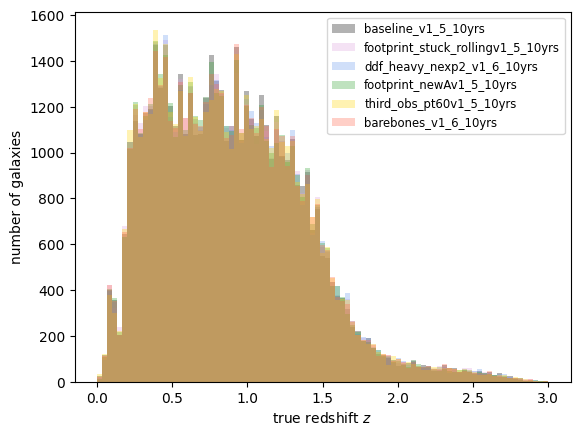

In [21]:
from matplotlib.pyplot import hist, xlabel, ylabel, legend

zbins = np.linspace(0, 3, 90)

for which_os in available_os:
  hist(z_cats[which_os]['z_true'], bins=zbins, alpha=0.3, color=os_colors[which_os], 
       label=os_names[which_os], density = False)
xlabel(r'true redshift $z$')
ylabel('number of galaxies')
legend(loc='upper right', fontsize='small')

We now need to define the notion of a 'conditional column', that is, p(z | X), where X are the photometric columns and z is the conditional column that is conditioned on the phtometry. 

In [22]:
drop_cols = ['ID', 'z_true', 'u', 'g',  'i', 'z', 'y', 
        'err_u', 'err_g', 'err_r', 'err_i', 'err_z', 'err_y', 
        'err_u-g', 'err_g-r', 'err_r-i', 'err_i-z', 'err_z-y']


Skip the next two cells if loading pre-trained flows

We now loop through the observing strategies and define a dictionary containing ensembles of normalizing flow objects that will be trained on the simulated data. 

In [ ]:
# mins = [0, 20, -5, -5, -5, -5, -5]
# maxs = [6, 30, 5, 5, 5, 5, 5]

# the data column is the one that is sampled and transformed by the flow
data_columns = ["z_true"]

all_cond_cols = {}
ensembles = dict()
K = 16

for which_os in available_os:#catalogs.keys():
 # the conditional columns are the columns that the flow is conditioned on
  conditional_columns = phot_cats[which_os].to_pandas().drop(drop_cols, axis = 1)
  all_cond_cols[os] = conditional_columns
  # print((os, conditional_columns))
  ndcol = len(data_columns)
  ncond = len(conditional_columns)
  ndim = ndcol+ncond

# first I create a bijector chain
# the first bijection is a standard scaler - but I'm not actually using it for standard scaling,
# the second bijection is a NeuralSplineCoupling. I told it to expect 6 conditions,
#     which will be the r mag and the galaxy colors


  bijector = Chain(
    StandardScaler(np.atleast_1d(1.6), np.atleast_1d(0.32)),
    NeuralSplineCoupling(B=5, n_conditions=6, K=K)
  )

# I set the latent distribution to a Uniform over (-5, 5)
# this range was chosen to match the NeuralSplineCoupling domain
# I chose a Uniform since all of the redshifts are drawn from a compact domain

  latent = Uniform(input_dim=ndcol, B=7) # this has changed. 

  info = f"Models z_true conditioned on galaxy colors and r mag from os {os}. K = 16"

  flowEns2 = FlowEnsemble(data_columns = data_columns, 
                           conditional_columns = conditional_columns,
                           bijector = bijector,
                           latent = latent,
                           info = info, 
                           N = 10
                            )
  ensembles[which_os] = flowEns2

This next cell trains the model for 150 epochs and saves the output.

In [ ]:
# tav_train, tav_test = {}, {}
# available_os = ['weather_1.2_v1.4_10yrs']

for which_os in available_os:#:
    ens  = ensembles[which_os]
    # get the data and make a train and test set
    cat = phot_cats[which_os].to_pandas()
    # cat_train = cat.sample(frac = 0.99)
    # cat_test = cat.drop(cat_train.index)
    cat_train = cat
    print(which_os)
    # train the flow on the given learning rate schedule
    loss = ens.train(cat_train,#conditional_columns], 
                               convolve_errs=False,
                       epochs = 150, verbose=True)
    # loss2 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 312)
    # loss3 = ens.train(cat_train, convolve_errs=True,
    #                    epochs = 30, seed = 231)
    
    # losses = {fname : # for each flow trained in the ensemble...
    #               [float(loss) # save the list of training losses
    #                for lossDict in [loss1]#, loss2, loss3]
    #                for loss in lossDict[fname]]
    #           for fname in loss1}
    
    # print the train and test loss
    train_loss = -np.mean(ens.log_prob(cat_train))
    # test_loss = -np.mean(ens.log_prob(cat_test))
    print(which_os, train_loss)#, test_loss)
    # post_trained[os] = ens
    # save the ensemble
    ens.save(prepend+f"pzflow_ensemble_for_{which_os}.pkl")
    # and the losses
    with open(prepend+f"losses_for_{which_os}.pkl", "wb") as file:
        pickle.dump({"losses": loss, 
                     "train loss": train_loss, 
                    #  "test loss": test_loss,
                     "train_ids": cat_train.index},
                    file)
        
    # mutual_information_lower_bound_train = ens.log_prob(cat_train, returnEnsemble=True)
    # mutual_information_lower_bound_test = ens.log_prob(cat_test, returnEnsemble=True)
    # tav_train[os] = mutual_information_lower_bound_train
    # tav_test[os] = mutual_information_lower_bound_test


1_4_y10
Flow 0
Training 150 epochs 
Loss:
(0) 1.5611
(1) -0.1636
(8) -1.1545
(15) -1.5164
(22) -1.5962
(29) -1.6130
(36) -1.6806
(43) -1.6922
(50) -1.7449
(57) -1.7328
(64) -1.7851
(71) -1.7851
(78) -1.7593
(85) -1.8057
(92) -1.6492
(99) -1.8577
(106) -1.8364
(113) -1.8672
(120) -1.8417
(127) -1.7882
(134) -1.8080
(141) -1.8916
(148) -1.7820
(150) -1.8539
Flow 1
Training 150 epochs 
Loss:
(0) 1.5317
(1) -0.1376
(8) -1.1402
(15) -1.4716
(22) -1.6061
(29) -1.6611
(36) -1.6925
(43) -1.7401
(50) -1.6700
(57) -1.7173
(64) -1.7608
(71) -1.7958
(78) -1.7757
(85) -1.8307
(92) -1.8311
(99) -1.7943
(106) -1.7901
(113) -1.8441
(120) -1.8385
(127) -1.8620
(134) -1.8683
(141) -1.8019
(148) -1.8298
(150) -1.8946
Flow 2
Training 150 epochs 
Loss:
(0) 1.4802
(1) -0.1925
(8) -1.3572
(15) -1.2559
(22) -1.6128
(29) -1.6420
(36) -1.7087
(43) -1.7369
(50) -1.7457
(57) -1.7843
(64) -1.8036
(71) -1.7321
(78) -1.7784
(85) -1.8263
(92) -1.8369
(99) -1.8416
(106) -1.7968
(113) -1.8533
(120) -1.8865
(127) -1.886

# Now, we open the saved flows by looping through a dictionary defining a mapping between observing strategy and each flow ensemble object. 



In [ ]:
# change to the Directory where the flows are saved.

# cd content/drive/MyDrive/Research/RubinPz

In [23]:
cd /content/drive/MyDrive/Research/RubinPz/trained_flows_losses_March

/content/drive/.shortcut-targets-by-id/1Jf5suAW7Ut5tICgfrfr9_mXqq3TWlP1f/RubinPz/trained_flows_losses_March


In [24]:
flows = {}
for which_os in available_os:
  flows[which_os] = [FlowEnsemble(file=f"pzflow_ensemble_for_{which_os}.pkl" )]

# just_tav = {}
# for os in available_os:
#   just_tav[os] = post_trained[os].log_prob(catalogs[os])

flows

{'1_4_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f1d12d00b80>],
 '4_38_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f1d12d00ca0>],
 '10_92_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f1d22505630>],
 '4_34_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f1d22521f90>],
 '7_61_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f1d225329e0>],
 '9_86_y10': [<pzflow.flowEnsemble.FlowEnsemble at 0x7f1d20b8b040>]}

# visualize training loss

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 4.25), dpi=100)


# with open(f"losses_for_10_92_y10.pkl", "rb") as file:
#     losses = pickle.load(file)["losses"]
    
# for i,ls in enumerate(losses.values()):
#     ax.plot(ls, alpha=0.5, label = str(i))
#     # ax.plot([], c=os_colors['10_92_y10'], label=i)
    
# ax.legend()
# ax.set(xlabel="Epoch", ylabel="Training loss")
# plt.show()

# Next, we compute the per galaxy log probability and aggregate thoise into TheLastMetric. This requires us to loop over the observing strategies, each of which is strored in flows[which_os]. 

In [ ]:
# all_logp = {}
# for which_os in available_os:
#   all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas(), returnEnsemble=True)
#                                  for f in flows[which_os] ], axis=0)

In [ ]:
# all_logp[which_os].shape

(1, 50000, 10)

In [ ]:
# zbins = np.linspace(0, 3, 32)
# avgtav = {}
# errtav = {}
# for which_os in available_os:
#   plotran = np.empty_like(zbins)
#   ploterr = np.empty_like(zbins)
#   if 'logprob' not in phot_cats[which_os].columns.values():
#     phot_cats[which_os]['logprob'] = all_logp[which_os]
#   for i, zmin in enumerate(zbins[:-1]):
#     zmax = zbins[i+1]
#     subset = phot_cats[which_os][(phot_cats[which_os]['z_true'] >= zmin) & (phot_cats[which_os]['z_true'] < zmax)]
#     # print((zmin, len(subset), zmax))
#     vals = subset['logprob']
#     mean = np.mean(vals)
#     std = np.std(vals)
#     plotran[i] = mean
#     ploterr[i] = std
#   avgtav[os] = plotran
#   errtav[os] = ploterr



In [ ]:
# for which_os in available_os:
#   plt.errorbar(zbins, avgtav[which_os], errtav[which_os], label=which_os, alpha=0.5)
# plt.legend()
# plt.xlabel('z_true')
# plt.ylabel(chr(0x05ea))

In [ ]:
# import scipy

In [ ]:
# def compute_last_metric(flow, photometry, redshift,
#                         entropy_nbins=120,
#                         entropy_range=[0.,3.]):
#   """ Computes the last metric given a trained flow and corresponding photometry
#   and redshift astropy tables
#   """
#   cat = photometry.to_pandas().merge(redshift.to_pandas())

#   # Computing the entropy H(z)
#   pz = scipy.stats.rv_histogram(np.histogram(cat['z_true'], bins=entropy_nbins,
#                                 range=entropy_range))
#   entropy = pz.entropy()

#   # Computing lower bound
#   mutual_information_lower_bound = flow.log_prob(cat) + entropy

#   return mutual_information_lower_bound

In [50]:
import scipy.stats as sps

# dictionary to hold all the MILB
all_tlm = {}
all_os_milb = {}

for os in available_os:
    print(os_names[os])
    # load the photometric catalog for this os
    cat = phot_cats[os].to_pandas().merge(z_cats[os].to_pandas())
  
  # Computing the entropy H(z)
    pz = sps.rv_histogram(np.histogram(phot_cat['z_true'], bins=128, range=[0,3]))
    entropy = pz.entropy()
    # TODO: double check that this isn't discrete entropy

  # Computing lower bound
    all_milb = []
    # print(len(flows[os]))
    # for i in range(10):
    milb = flows[os][0].log_prob(cat, returnEnsemble=True, err_samples=10) + entropy
    # print(milb)
    all_milb.append(np.array(milb))
    print(np.shape(all_milb[-1]))
    all_tlm[os] = milb.mean(axis=0)
    print(all_tlm[os])
    all_os_milb[os] = np.array(all_milb)
    # print(all_tlm[os].shape)

#TODO: actually need to add these errors in quadrature
    print((os_names[os], np.mean(all_tlm[os]), np.std(all_tlm[os])))

baseline_v1_5_10yrs
(50000, 10)
[2.4604783 2.5011501 2.4943297 2.4724402 2.5350783 2.4996772 2.4784184
 2.4653683 2.4861875 2.3573503]
('baseline_v1_5_10yrs', Array(2.4750478, dtype=float32), Array(0.04423154, dtype=float32))
footprint_stuck_rollingv1_5_10yrs
(50000, 10)
[2.3645792 2.3304696 2.411508  2.4024177 2.398248  2.400421  2.315019
 2.3771777 2.3548424 2.3973513]
('footprint_stuck_rollingv1_5_10yrs', Array(2.3752034, dtype=float32), Array(0.03141779, dtype=float32))
ddf_heavy_nexp2_v1_6_10yrs
(50000, 10)
[2.4166086 2.4385338 2.4567518 2.3754888 2.438371  2.426425  2.4170313
 2.4065468 2.462972  2.3970432]
('ddf_heavy_nexp2_v1_6_10yrs', Array(2.4235775, dtype=float32), Array(0.02549737, dtype=float32))
footprint_newAv1_5_10yrs
(50000, 10)
[2.4518409 2.4603455 2.4596548 2.4447193 2.491035  2.4755933 2.466361
 2.4517696 2.461784  2.4107459]
('footprint_newAv1_5_10yrs', Array(2.4573848, dtype=float32), Array(0.01993891, dtype=float32))
third_obs_pt60v1_5_10yrs
(50000, 10)
[2.443947

In [44]:
# # Computing metric for each observing strategy
# all_tlm = {}
# for which_os in available_os:
#   all_tlm[which_os] = np.stack([(compute_last_metric(f,
#                                           phot_cats[which_os],
#                                           z_cats[which_os], entropy_nbins=60)) for f in flows[which_os] ], axis=0)
#   print((os_names[which_os], np.mean(all_tlm[which_os]), np.std(np.mean(all_tlm[which_os], axis=1))))



# Histogram of TLM values for each observing strategy

In [42]:
tavbins = np.linspace(2.3, 2.6, 300)

Text(0, 0.5, 'probability density $p($ת$)$')

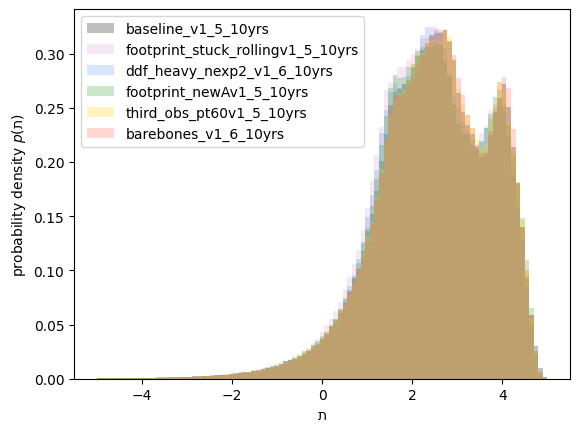

In [67]:
overall_tavbins = np.linspace(-5, 5, 100)

for os in available_os:
  # print(all_os_milb[os][0].shape)
  plt.hist(all_os_milb[os][0].flatten(), alpha=0.25, label=os_names[os], density=True, color=os_colors[os], bins=overall_tavbins)
plt.legend()
# plt.xlim(-5,4)
plt.xlabel(chr(0x05ea))#r'$\mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]$')
# plt.yticks([])
# plt.savefig(prepend+'all_combos_histogram.pdf')
plt.ylabel(r'probability density $p($'+chr(0x05ea)+'$)$')

In [1]:
# for one_os in all_os_milb:
#   print(all_os_milb[one_os].shape)

In [39]:
all_tlm

{'1_4_y10': Array([2.4604783, 2.5011501, 2.4943297, 2.4724402, 2.5350783, 2.4996772,
        2.4784184, 2.4653683, 2.4861875, 2.3573503], dtype=float32),
 '4_38_y10': Array([2.3645792, 2.3304696, 2.411508 , 2.4024177, 2.398248 , 2.400421 ,
        2.315019 , 2.3771777, 2.3548424, 2.3973513], dtype=float32),
 '10_92_y10': Array([2.4166086, 2.4385338, 2.4567518, 2.3754888, 2.438371 , 2.426425 ,
        2.4170313, 2.4065468, 2.462972 , 2.3970432], dtype=float32),
 '4_34_y10': Array([2.4518409, 2.4603455, 2.4596548, 2.4447193, 2.491035 , 2.4755933,
        2.466361 , 2.4517696, 2.461784 , 2.4107459], dtype=float32),
 '7_61_y10': Array([2.4439476, 2.4808433, 2.503436 , 2.50247  , 2.485935 , 2.5446448,
        2.5049527, 2.487534 , 2.4714415, 2.4329627], dtype=float32),
 '9_86_y10': Array([2.4971552, 2.4097605, 2.5607693, 2.5354455, 2.4545164, 2.4732049,
        2.5477922, 2.5055268, 2.5214343, 2.541511 ], dtype=float32)}

Text(0, 0.5, 'probability density $p($ת$)$')

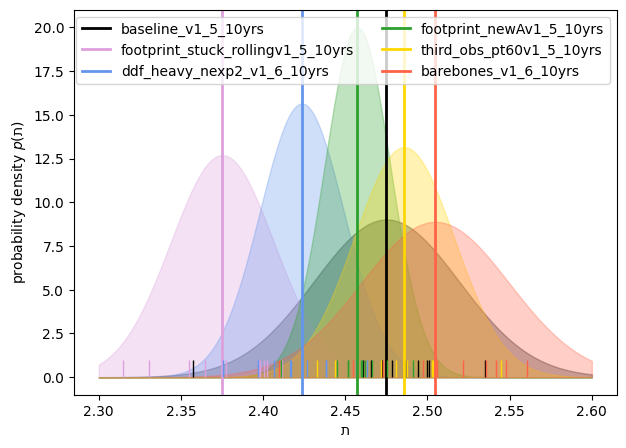

In [48]:
#TODO: more flows in the ensemble

plt.figure(figsize=(7,5))
for which_os in available_os:
  # plt.hist(all_tlm[which_os],#np.mean([(all_logp[which_os].T[j]) for j in range(10)], axis=1), 
  #          bins=tavbins, alpha=0.6,
  #      color=os_colors[which_os], label=os_names[which_os])
  
  # for j in range(10):
  #   plt.axvline(np.mean(all_logp[which_os].T[j]), alpha=0.6,
  #      color=os_colors[which_os])
  plt.axvline(np.mean(all_tlm[which_os]), color=os_colors[which_os], linewidth=2, label=os_names[which_os])
  plt.vlines(all_tlm[which_os], 0, 1, color=os_colors[which_os], linewidth=1)
  plt.fill_between(tavbins, sps.norm(np.mean(all_tlm[which_os]), np.std(all_tlm[which_os])).pdf(tavbins), 
                   alpha=0.3, color=os_colors[which_os])
plt.legend(ncol=2)
plt.xlabel(chr(0x05ea))
plt.ylabel(r'probability density $p($'+chr(0x05ea)+'$)$')
# plt.savefig('metrics.pdf', bbox_inches = 'tight', pad_inches = 0 )

In [83]:
all_os_milb[which_os].shape

(1, 50000, 10)

# And compute the average value of the last metric in redshift bins. 

In [95]:
# all_logp = {}
# for which_os in available_os:
#   all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas())
#                                  for f in flows[which_os] ], axis=0)

# from scipy import stats
n=32
b = sps.mstats.mquantiles(z_cats_no_nan[which_os]['z_true'], np.linspace(0,1,n, endpoint=True))
# print(len(z_cats_no_nan[which_os]['z_true']))

mis = {}

for which_os in available_os:
  inds = np.digitize(z_cats_no_nan[which_os]['z_true'], b) -1 

  print(len(inds))

  all_res = []
  for j in range(10):
    res = np.zeros(n-1)
    for i in range(n-1):
      # res[i] = np.mean( np.mean((all_logp[which_os].flatten()[inds == i])))
      res[i] = np.mean(all_os_milb[which_os][0].T[j][inds == i])
    all_res.append(res)
  mis[which_os] = np.array(all_res)


50000
50000
50000
50000
50000
50000


In [96]:
mis

{'1_4_y10': array([[3.0298667 , 3.41424894, 3.444556  , 3.4828105 , 3.48367095,
         3.28593111, 3.01353741, 3.09505177, 3.30359507, 3.4428792 ,
         3.57052732, 3.38977671, 3.0524776 , 2.34693313, 2.1238811 ,
         2.11708212, 2.23251414, 2.4693048 , 2.38756371, 2.12051678,
         1.87890744, 1.62109888, 1.65557468, 1.44695878, 1.25698853,
         1.26703298, 1.36619449, 1.74181175, 2.05709791, 2.12075734,
         1.0562253 ],
        [3.18349457, 3.64783025, 3.69049668, 3.73672175, 3.65690541,
         3.42719197, 3.15546894, 3.22904682, 3.37800813, 3.46138453,
         3.57152033, 3.40104771, 3.03574538, 2.38808584, 2.1142168 ,
         2.13064075, 2.25558877, 2.45847964, 2.37147284, 2.13771462,
         1.84568799, 1.6447283 , 1.64169252, 1.38139534, 1.17174923,
         1.23553956, 1.40322948, 1.69948924, 1.98373914, 2.03706789,
         1.0617286 ],
        [3.15774822, 3.65364432, 3.70711851, 3.76164198, 3.6254425 ,
         3.47059178, 3.14369845, 3.10833645, 3.2

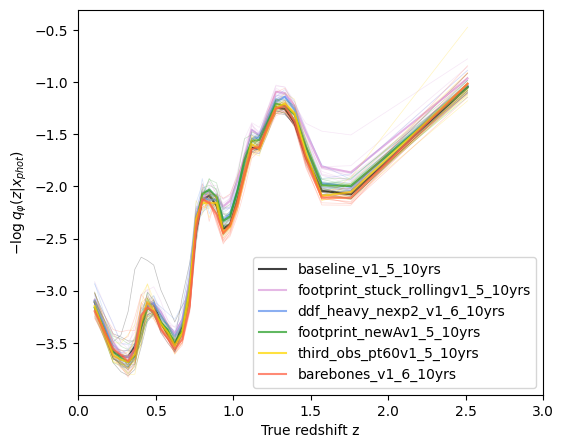

In [102]:
b_centers = 0.5*(b[1:] + b[:-1])

plt.figure(figsize=(6,5))
for which_os in available_os:
  for j in range(10):
    plt.plot(b_centers, -mis[which_os][j], color=os_colors[which_os], alpha=0.25, linewidth=0.5)
  plt.plot(b_centers, np.mean(-mis[which_os], axis=0), label=os_names[which_os], color=os_colors[which_os], alpha=0.75)
plt.legend()
plt.ylabel(r'$- \log q_{\varphi} (z | x_{phot})$')
plt.xlabel('True redshift z')
plt.xlim(0,3);
# TODO: fix y axis: this is -MILB, including entropy and as f(z)

50000
50000
50000
50000
50000
50000
50000


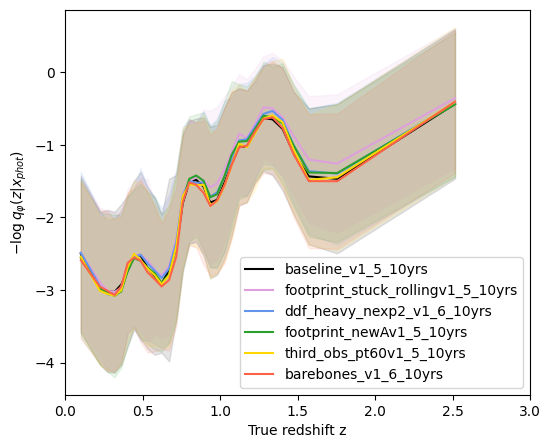

In [ ]:
# all_logp = {}
# for which_os in available_os:
#   all_logp[which_os] = np.stack([f.log_prob(phot_cats[which_os].to_pandas())
#                                  for f in flows[which_os] ], axis=0)

from scipy import stats
n=32
b = stats.mstats.mquantiles(z_cats_no_nan[which_os]['z_true'], np.linspace(0,1,n, endpoint=True))
print(len(z_cats_no_nan[which_os]['z_true']))

var2 = {}

for which_os in available_os:
  inds = np.digitize(z_cats_no_nan[which_os]['z_true'], b) -1 

  print(len(inds))


  vars = np.zeros(n-1)
  for i in range(n-1):
    # res[i] = np.mean( np.mean((all_logp[which_os].flatten()[inds == i])))
    vars[i] = np.mean( np.var([(all_logp[which_os].T[j].flatten()[inds == i]) for j in range(10)]))
    
  var2[which_os] = np.sqrt(vars)

b_centers = 0.5*(b[1:] + b[:-1])

plt.figure(figsize=(6,5))
for i, which_os in enumerate(available_os):
  plt.plot(b_centers, - mis[which_os], label=os_names[which_os], color=os_colors[which_os])
  plt.fill_between(b_centers, - mis[which_os] - var2[which_os], - mis[which_os] + var2[which_os], color=os_colors[which_os], edgecolor=os_colors[which_os], alpha = 0.1)
plt.legend()
plt.ylabel(r'$- \log q_{\varphi} (z | x_{phot})$')
plt.xlabel('True redshift z')
plt.xlim(0,3);

# Same as before, with baseline scenario subtracted off.

(-0.6, 0.6)

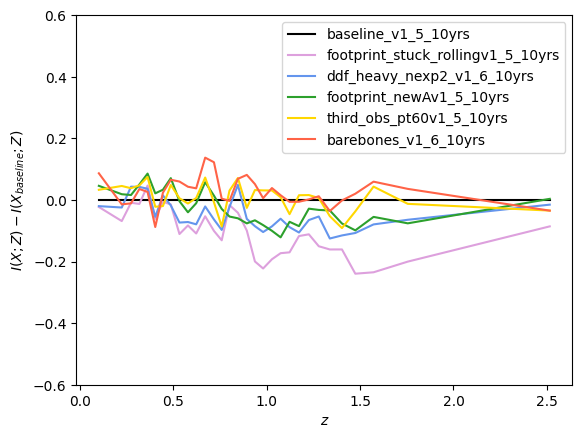

In [ ]:
for which_os in available_os:
  plt.plot(b_centers, mis[which_os] - mis['1_4_y10'], label=os_names[which_os], color=os_colors[which_os])
plt.legend(loc='upper right')
plt.xlabel('$z$')
plt.ylabel('$I(X ; Z) - I(X_{baseline} ; Z)$');
plt.savefig('figure4.pdf')
plt.ylim(-0.6,0.6)